In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

### Les données de la qualité de l'air  ###

In [2]:
df = pd.read_csv('qualite-de-lair-mesuree-dans-la-station-auber.csv',delimiter=';')
print(df.head(15))

                   DATE/HEURE  NO NO2 PM10 PM2.5  CO2  TEMP  HUMI
0   2024-04-15T00:00:00+02:00  <2  25   67    27  490  21,9  43,3
1   2024-04-14T23:00:00+02:00  <2  32   72    32  501  22,1    42
2   2024-04-14T22:00:00+02:00  <2  33   83    38  526  22,4  42,8
3   2024-04-14T21:00:00+02:00  <2  42   64    24  563  22,8  41,8
4   2024-04-14T20:00:00+02:00   2  41   85    34  606    23    44
5   2024-04-14T19:00:00+02:00   2  40   84    34  630  23,1  44,8
6   2024-04-14T18:00:00+02:00  <2  35   66    24  605    23    43
7   2024-04-14T17:00:00+02:00  <2  30   88    32  592  22,8  43,5
8   2024-04-14T16:00:00+02:00  <2  26   72    24  579  22,6  43,8
9   2024-04-14T15:00:00+02:00  <2  29   58    19  560  22,3  43,8
10  2024-04-14T14:00:00+02:00  <2  28   52    14  542    22  44,1
11  2024-04-14T13:00:00+02:00  <2  24   62    21  534  21,7  46,1
12  2024-04-14T12:00:00+02:00  <2  26   62    23  522  21,4  48,2
13  2024-04-14T11:00:00+02:00  <2  27   69    27  507  21,3  48,8
14  2024-0

## Nettoyage de données

In [3]:

# Remplacer les valeurs 'ND' par 0
df.replace('ND', 0, inplace=True)

# Remplacer les valeurs inférieures à un certain nombre par ce nombre moins 1
nombre_limite = 10  # Mettez ici votre nombre limite
df.replace(to_replace=r'^<(\d+)$', value=r'\1', regex=True, inplace=True)
df['NO'] = df['NO'].str.extract(r'(\d+)')
df['NO2'] = df['NO2'].str.extract(r'(\d+)')
df['PM10'] = df['PM10'].str.extract(r'(\d+)')
df['PM2.5'] = df['PM2.5'].str.extract(r'(\d+)')
df['CO2'] = df['CO2'].str.extract(r'(\d+)')
df['TEMP'] = df['TEMP'].str.extract(r'(\d+)')
df['HUMI'] = df['HUMI'].str.extract(r'(\d+)')


# Convertir toutes les colonnes en type numérique
df = df.apply(pd.to_numeric, errors='ignore')

# Vérifier les résultats
df.head(10)

/var/folders/f0/xxy9v_lx1s58xs4t0mygrc9r0000gn/T/ipykernel_6237/3486932706.py:17: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


,DATE/HEURE,NO,NO2,PM10,PM2.5,CO2,TEMP,HUMI
0,2024-04-15T00:00:00+02:00,2.0,25.0,67.0,27.0,490.0,21.0,43.0
1,2024-04-14T23:00:00+02:00,2.0,32.0,72.0,32.0,501.0,22.0,42.0
2,2024-04-14T22:00:00+02:00,2.0,33.0,83.0,38.0,526.0,22.0,42.0
3,2024-04-14T21:00:00+02:00,2.0,42.0,64.0,24.0,563.0,22.0,41.0
4,2024-04-14T20:00:00+02:00,2.0,41.0,85.0,34.0,606.0,23.0,44.0
5,2024-04-14T19:00:00+02:00,2.0,40.0,84.0,34.0,630.0,23.0,44.0
6,2024-04-14T18:00:00+02:00,2.0,35.0,66.0,24.0,605.0,23.0,43.0
7,2024-04-14T17:00:00+02:00,2.0,30.0,88.0,32.0,592.0,22.0,43.0
8,2024-04-14T16:00:00+02:00,2.0,26.0,72.0,24.0,579.0,22.0,43.0
9,2024-04-14T15:00:00+02:00,2.0,29.0,58.0,19.0,560.0,22.0,43.0


In [4]:

def moyenne_sauf_zero(window):
    valeurs_numeriques = [float(x) for x in window if x != 0]
    if valeurs_numeriques:
        return np.mean(valeurs_numeriques)
    else:
        return 0
        


df["PM10_avg"] = df["PM10"].rolling(window = 24).apply(moyenne_sauf_zero, raw=True)
df["PM2.5_avg"] = df["PM2.5"].rolling(window = 24).apply(moyenne_sauf_zero, raw=True)
#df["SO2_24hr_avg"] = df["SO2"].rolling(window = 24, min_periods = 16).mean().values
df["NO_avg"] = df["NO"].rolling(window = 24).apply(moyenne_sauf_zero, raw=True)
df["NO2_avg"] = df["NO2"].rolling(window = 24).apply(moyenne_sauf_zero, raw=True)
#df["NH3_24hr_avg"] = df.groupby("StationId")["NH3"].rolling(window = 24, min_periods = 16).mean().values
df["CO2_avg"] = df["CO2"].rolling(window = 24).apply(moyenne_sauf_zero, raw=True)
df = df.drop(df.index[:24])

df.head(10)

,DATE/HEURE,NO,NO2,PM10,PM2.5,CO2,TEMP,HUMI,PM10_avg,PM2.5_avg,NO_avg,NO2_avg,CO2_avg
24,2024-04-14T00:00:00+02:00,20.0,53.0,128.0,59.0,604.0,23.0,53.0,67.333333,27.958333,17.750000,33.791667,533.375000
25,2024-04-13T23:00:00+02:00,10.0,52.0,107.0,47.0,594.0,23.0,52.0,68.791667,28.583333,18.083333,34.625000,537.250000
26,2024-04-13T22:00:00+02:00,5.0,47.0,113.0,52.0,615.0,24.0,51.0,70.041667,29.166667,18.208333,35.208333,540.958333
27,2024-04-13T21:00:00+02:00,6.0,50.0,97.0,39.0,660.0,24.0,47.0,71.416667,29.791667,18.375000,35.541667,545.000000
28,2024-04-13T20:00:00+02:00,5.0,49.0,147.0,62.0,709.0,24.0,44.0,74.000000,30.958333,18.500000,35.875000,549.291667
29,2024-04-13T19:00:00+02:00,4.0,41.0,157.0,65.0,761.0,24.0,45.0,77.041667,32.250000,18.583333,35.916667,554.750000
30,2024-04-13T18:00:00+02:00,2.0,34.0,117.0,47.0,729.0,24.0,45.0,79.166667,33.208333,18.583333,35.875000,559.916667
31,2024-04-13T17:00:00+02:00,2.0,35.0,95.0,38.0,716.0,24.0,46.0,79.458333,33.458333,18.583333,36.083333,565.083333
32,2024-04-13T16:00:00+02:00,2.0,33.0,98.0,34.0,686.0,23.0,46.0,80.541667,33.875000,18.583333,36.375000,569.541667
33,2024-04-13T15:00:00+02:00,2.0,30.0,120.0,49.0,646.0,23.0,49.0,83.125000,35.125000,18.583333,36.416667,573.125000


## Calculate Sub-Index

In [5]:
## PM2.5 Sub-Index calculation
def get_PM25_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

df["PM2.5_SubIndex"] = df["PM2.5_avg"].apply(lambda x: get_PM25_subindex(x))

## PM10 Sub-Index calculation
def get_PM10_subindex(x):
    if x <= 50:
        return x
    elif x <= 100:
        return x
    elif x <= 250:
        return 100 + (x - 100) * 100 / 150
    elif x <= 350:
        return 200 + (x - 250)
    elif x <= 430:
        return 300 + (x - 350) * 100 / 80
    elif x > 430:
        return 400 + (x - 430) * 100 / 80
    else:
        return 0

df["PM10_SubIndex"] = df["PM10_avg"].apply(lambda x: get_PM10_subindex(x))


## NOx Sub-Index calculation
def get_NOx_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0

df["NO_SubIndex"] = df["NO_avg"].apply(lambda x: get_NOx_subindex(x))
df["NO2_SubIndex"] = df["NO2_avg"].apply(lambda x: get_NOx_subindex(x))


## CO Sub-Index calculation
# def get_CO_subindex(x):
#     if x <= 1:
#         return x * 50 / 1
#     elif x <= 2:
#         return 50 + (x - 1) * 50 / 1
#     elif x <= 10:
#         return 100 + (x - 2) * 100 / 8
#     elif x <= 17:
#         return 200 + (x - 10) * 100 / 7
#     elif x <= 34:
#         return 300 + (x - 17) * 100 / 17
#     elif x > 34:
#         return 400 + (x - 34) * 100 / 17
#     else:
#         return 0

# df["CO2_SubIndex"] = df["CO2_avg"].apply(lambda x: get_CO_subindex(x))

## AQI BITBUCKET

In [6]:
## AQI bucketing
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

df["Checks"] = (df["PM2.5_SubIndex"] > 0).astype(int) + \
                (df["PM10_SubIndex"] > 0).astype(int) + \
                (df["NO_SubIndex"] > 0).astype(int) + \
                (df["NO2_SubIndex"] > 0).astype(int) 

df["AQI_calculated"] = round(df[["PM2.5_SubIndex", "PM10_SubIndex", "NO_SubIndex",
                                 "NO2_SubIndex"]].max(axis = 1))
df.loc[df["PM2.5_SubIndex"] + df["PM10_SubIndex"] <= 0, "AQI_calculated"] = np.NaN
df.loc[df.Checks < 3, "AQI_calculated"] = np.NaN

df["AQI_bucket_calculated"] = df["AQI_calculated"].apply(lambda x: get_AQI_bucket(x))
df[~df.AQI_calculated.isna()].head(13)

,DATE/HEURE,NO,NO2,PM10,PM2.5,CO2,TEMP,HUMI,PM10_avg,PM2.5_avg,NO_avg,NO2_avg,CO2_avg,PM2.5_SubIndex,PM10_SubIndex,NO_SubIndex,NO2_SubIndex,Checks,AQI_calculated,AQI_bucket_calculated
24,2024-04-14T00:00:00+02:00,20.0,53.0,128.0,59.0,604.0,23.0,53.0,67.333333,27.958333,17.750000,33.791667,533.375000,46.597222,67.333333,22.187500,42.239583,4,67.0,Satisfactory
25,2024-04-13T23:00:00+02:00,10.0,52.0,107.0,47.0,594.0,23.0,52.0,68.791667,28.583333,18.083333,34.625000,537.250000,47.638889,68.791667,22.604167,43.281250,4,69.0,Satisfactory
26,2024-04-13T22:00:00+02:00,5.0,47.0,113.0,52.0,615.0,24.0,51.0,70.041667,29.166667,18.208333,35.208333,540.958333,48.611111,70.041667,22.760417,44.010417,4,70.0,Satisfactory
27,2024-04-13T21:00:00+02:00,6.0,50.0,97.0,39.0,660.0,24.0,47.0,71.416667,29.791667,18.375000,35.541667,545.000000,49.652778,71.416667,22.968750,44.427083,4,71.0,Satisfactory
28,2024-04-13T20:00:00+02:00,5.0,49.0,147.0,62.0,709.0,24.0,44.0,74.000000,30.958333,18.500000,35.875000,549.291667,51.597222,74.000000,23.125000,44.843750,4,74.0,Satisfactory
29,2024-04-13T19:00:00+02:00,4.0,41.0,157.0,65.0,761.0,24.0,45.0,77.041667,32.250000,18.583333,35.916667,554.750000,53.750000,77.041667,23.229167,44.895833,4,77.0,Satisfactory
30,2024-04-13T18:00:00+02:00,2.0,34.0,117.0,47.0,729.0,24.0,45.0,79.166667,33.208333,18.583333,35.875000,559.916667,55.347222,79.166667,23.229167,44.843750,4,79.0,Satisfactory
31,2024-04-13T17:00:00+02:00,2.0,35.0,95.0,38.0,716.0,24.0,46.0,79.458333,33.458333,18.583333,36.083333,565.083333,55.763889,79.458333,23.229167,45.104167,4,79.0,Satisfactory
32,2024-04-13T16:00:00+02:00,2.0,33.0,98.0,34.0,686.0,23.0,46.0,80.541667,33.875000,18.583333,36.375000,569.541667,56.458333,80.541667,23.229167,45.468750,4,81.0,Satisfactory
33,2024-04-13T15:00:00+02:00,2.0,30.0,120.0,49.0,646.0,23.0,49.0,83.125000,35.125000,18.583333,36.416667,573.125000,58.541667,83.125000,23.229167,45.520833,4,83.0,Satisfactory


## PREDICT AIR QUALITY

In [7]:
# Diviser les données en ensembles d'entraînement et de test
df.dropna(inplace=True)

X = df.drop(columns=["AQI_bucket_calculated", "DATE/HEURE"])  # Features
y = df["AQI_bucket_calculated"]  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer et entraîner le modèle (Random Forest Classifier par exemple)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluer les performances du modèle
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 1.0


## Résultats sous la forme d’un graphique

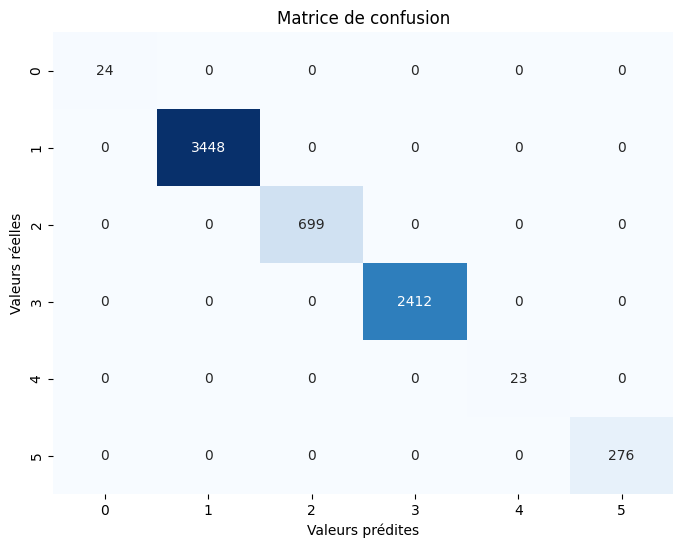

In [8]:
# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Afficher la matrice de confusion sous forme de heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion')
plt.show()